In [1]:
from os.path import join
from os import makedirs
import matplotlib.pyplot as plt
from matplotlib import gridspec
# from unet import CBIS_DDSM_get_DataLoader

# from skimage import io
import SimpleITK as sitk
import numpy as np
import glob
import pandas
import cv2


In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

img = sitk.GetArrayFromImage(sitk.ReadImage('/usr/xtmp/jly16/mammoproj/nnunet_integration_tmp/AllOracleRuns/Run_2_20_auto_oracle_test_uniform_20_42/Iter0/NNUNetSegmentations/DP_AABO_1432_1.nii.gz'))


ModuleNotFoundError: No module named 'SimpleITK'

In [ ]:
img.shape

## Some function definitions

In [2]:
def display_image_annotation(filepath,annotations,png=False, niigz = False):
    ncols, nrows = 3, len(filepath)
    fig = plt.figure(constrained_layout=False)
    fig.set_size_inches(9, 3*len(filepath)+1)
    fig.tight_layout()
    spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig,hspace=0,wspace=0)
    
    anno_opts = dict(xy=(0.05, 0.05), xycoords='axes fraction', va='bottom', ha='left',color='cyan',fontweight='extra bold',fontsize='8')

    f_axes = []
    for row in range(nrows):
        f_axes.append([])
        for col in range(ncols):
            f_axes[-1].append(fig.add_subplot(spec[row, col]))

    for ax_num, ax in enumerate(f_axes[0]):
            if ax_num == 0:
                ax.set_title("Image", fontdict=None, loc='left', color = "k")
            elif ax_num == 1:
                ax.set_title("Segmentation", fontdict=None, loc='left', color = "k")
            elif ax_num == 2:
                ax.set_title("Overlay", fontdict=None, loc='left', color = "k")

    for row in range(nrows):
        if png:
            #image = np.array(Image.open(filepath[row][0]))
            #mask = np.array(Image.open(filepath[row][1]))
            image = (cv2.imread(filepath[row][0]))/255
            mask = (255 - cv2.imread(filepath[row][1]))/255
            image_and_mask = np.stack([image,mask])
        if niigz: 
            image = sitk.GetArrayFromImage(sitk.ReadImage(filepath[row][0]))[0]
            mask = sitk.GetArrayFromImage(sitk.ReadImage(filepath[row][1]))[0]
            image_and_mask = np.stack([image,mask])
        else:
            image_and_mask = np.load(filepath[row])
        f_axes[row][0].imshow(image_and_mask[0],cmap='gray')
        f_axes[row][0].set_axis_off()
        
        f_axes[row][1].imshow(image_and_mask[1],cmap='gray')
        f_axes[row][1].set_axis_off()

        heatmap = cv2.applyColorMap(np.uint8(255*(1-image_and_mask[1])), cv2.COLORMAP_AUTUMN)
        heatmap = np.float32(heatmap) / 255
        heatmap = heatmap[...,::-1]
        if png:
            img = 0.6 * image_and_mask[0] + 0.3*heatmap
        else:
            img = 0.6 * np.stack([image_and_mask[0],image_and_mask[0],image_and_mask[0]],axis=-1) + 0.3*heatmap
        f_axes[row][2].imshow(img)
        f_axes[row][2].set_axis_off()
        
        f_axes[row][0].annotate(annotations[row],**anno_opts)
    return fig


In [3]:
def display_image_annotation_AB(filepath, annotations, table_data, table_row_labels, overlay = True):
    ncols, nrows = 5, len(filepath)
    fig = plt.figure(constrained_layout=False)
    fig.set_size_inches(15, 3*len(filepath)+1)
    fig.tight_layout()
    spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig,hspace=0,wspace=0)
    
    anno_opts = dict(xy=(0.05, 0.05), xycoords='axes fraction', va='bottom', ha='left',color='cyan',fontweight='extra bold',fontsize='8')

    f_axes = []
    for row in range(nrows):
        f_axes.append([])
        for col in range(ncols):
            f_axes[-1].append(fig.add_subplot(spec[row, col]))

    for ax_num, ax in enumerate(f_axes[0]):
            if ax_num == 0:
                ax.set_title("Image", fontdict=None, loc='left', color = "k")
            elif ax_num == 1:
                ax.set_title("Manual A", fontdict=None, loc='left', color = "k")
            elif ax_num == 2:
                ax.set_title("Manual B", fontdict=None, loc='left', color = "k")
            elif ax_num == 3:
                ax.set_title("Prediction", fontdict=None, loc='left', color = "k")
            elif ax_num == 4:
                ax.set_title("IoU", fontdict=None, loc='left', color = "k")

    for row in range(nrows):
        images = []
        for col in range(4):
            images.append(sitk.GetArrayFromImage(sitk.ReadImage(filepath[row][col]))[0])
            
        f_axes[row][0].imshow(images[0],cmap='gray')
        f_axes[row][0].set_axis_off()
        
        
        for col in range(ncols - 2):
            if overlay:
                heatmap = cv2.applyColorMap(np.uint8(255*(1-images[col+1])), cv2.COLORMAP_AUTUMN)
                heatmap = np.float32(heatmap) / 255
                heatmap = heatmap[...,::-1]

                img = 0.6 * np.stack([images[0],images[0],images[0]],axis=-1) + 0.3*heatmap
                f_axes[row][col+1].imshow(img)
                f_axes[row][col+1].set_axis_off()
            else: 
                f_axes[row][col+1].imshow(images[col+1],cmap='cividis')
                f_axes[row][col+1].set_axis_off()
        tb = f_axes[row][ncols-1].table(cellText=table_data[row], rowLabels=table_row_labels, 
                                   loc = 'upper right', 
                                   colWidths = [.4,.6])

        tb.scale(1, 2)
        tb.auto_set_font_size(False)
        tb.set_fontsize(16)
        f_axes[row][ncols-1].set_axis_off()

        f_axes[row][0].annotate(annotations[row],**anno_opts)
    return fig

In [4]:
def convert_2d_image_to_nifti(img, output_filename_truncated: str, spacing=(999, 1, 1),
                              transform=None, is_seg: bool = False) -> None:
    """
    Reads an image (must be a format that it recognized by skimage.io.imread) and converts it into a series of niftis.
    The image can have an arbitrary number of input channels which will be exported separately (_0000.nii.gz,
    _0001.nii.gz, etc for images and only .nii.gz for seg).
    Spacing can be ignored most of the time.
    !!!2D images are often natural images which do not have a voxel spacing that could be used for resampling. These images
    must be resampled by you prior to converting them to nifti!!!
    Datasets converted with this utility can only be used with the 2d U-Net configuration of nnU-Net
    If Transform is not None it will be applied to the image after loading.
    Segmentations will be converted to np.uint32!
    :param is_seg:
    :param transform:
    :param input_filename:
    :param output_filename_truncated: do not use a file ending for this one! Example: output_name='./converted/image1'. This
    function will add the suffix (_0000) and file ending (.nii.gz) for you.
    :param spacing:
    :return:
    """

    if transform is not None:
        img = transform(img)

    if len(img.shape) == 2:  # 2d image with no color channels
        img = img[None, None]  # add dimensions
    else:
        assert len(img.shape) == 3, "image should be 3d with color channel last but has shape %s" % str(img.shape)
        # we assume that the color channel is the last dimension. Transpose it to be in first
        img = img.transpose((2, 0, 1))
        # add third dimension
        img = img[:, None]

    # image is now (c, x, x, z) where x=1 since it's 2d
    if is_seg:
        assert img.shape[0] == 1, 'segmentations can only have one color channel, not sure what happened here'

    for j, i in enumerate(img):

        if is_seg:
            i = i.astype(np.uint32)

        itk_img = sitk.GetImageFromArray(i)
        itk_img.SetSpacing(list(spacing)[::-1])
        if not is_seg:
            # print(f"saving to {output_filename_truncated} _%04.0d.nii.gz ")
            sitk.WriteImage(itk_img, output_filename_truncated + "_%04.0d.nii.gz" % j)
        else:
            # print(f"saving to {output_filename_truncated}.nii.gz")
            sitk.WriteImage(itk_img, output_filename_truncated + ".nii.gz")
        return itk_img

In [5]:
#    Copyright 2020 Division of Medical Image Computing, German Cancer Research Center (DKFZ), Heidelberg, Germany
#
#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at
#
#        http://www.apache.org/licenses/LICENSE-2.0
#
#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.


from typing import Tuple
import numpy as np
from batchgenerators.utilities.file_and_folder_operations import *


def get_identifiers_from_splitted_files(folder: str):
    uniques = np.unique([i[:-12] for i in subfiles(folder, suffix='.nii.gz', join=False)])
    return uniques


def generate_dataset_json(output_file: str, imagesTr_dir: str, imagesTs_dir: str, modalities: Tuple,
                          labels: dict, dataset_name: str, sort_keys=True, license: str = "hands off!", dataset_description: str = "",
                          dataset_reference="", dataset_release='0.0'):
    """
    :param output_file: This needs to be the full path to the dataset.json you intend to write, so
    output_file='DATASET_PATH/dataset.json' where the folder DATASET_PATH points to is the one with the
    imagesTr and labelsTr subfolders
    :param imagesTr_dir: path to the imagesTr folder of that dataset
    :param imagesTs_dir: path to the imagesTs folder of that dataset. Can be None
    :param modalities: tuple of strings with modality names. must be in the same order as the images (first entry
    corresponds to _0000.nii.gz, etc). Example: ('T1', 'T2', 'FLAIR').
    :param labels: dict with int->str (key->value) mapping the label IDs to label names. Note that 0 is always
    supposed to be background! Example: {0: 'background', 1: 'edema', 2: 'enhancing tumor'}
    :param dataset_name: The name of the dataset. Can be anything you want
    :param sort_keys: In order to sort or not, the keys in dataset.json
    :param license:
    :param dataset_description:
    :param dataset_reference: website of the dataset, if available
    :param dataset_release:
    :return:
    """
    train_identifiers = get_identifiers_from_splitted_files(imagesTr_dir)

    if imagesTs_dir is not None:
        test_identifiers = get_identifiers_from_splitted_files(imagesTs_dir)
    else:
        test_identifiers = []

    json_dict = {}
    json_dict['name'] = dataset_name
    json_dict['description'] = dataset_description
    json_dict['tensorImageSize'] = "4D"
    json_dict['reference'] = dataset_reference
    json_dict['licence'] = license
    json_dict['release'] = dataset_release
    json_dict['modality'] = {str(i): modalities[i] for i in range(len(modalities))}
    json_dict['labels'] = {str(i): labels[i] for i in labels.keys()}

    json_dict['numTraining'] = len(train_identifiers)
    json_dict['numTest'] = len(test_identifiers)
    json_dict['training'] = [
        {'image': "./imagesTr/%s.nii.gz" % i, "label": "./labelsTr/%s.nii.gz" % i} for i
        in
        train_identifiers]
    json_dict['test'] = ["./imagesTs/%s.nii.gz" % i for i in test_identifiers]

    if not output_file.endswith("dataset.json"):
        print("WARNING: output file name is not dataset.json! This may be intentional or not. You decide. "
              "Proceeding anyways...")
    save_json(json_dict, os.path.join(output_file), sort_keys=sort_keys)

## Some path definitions

In [6]:
# train_images_filename='duke_total_test.txt'
# test_images_filename='duke_total_train.txt'
# train_images_directory="/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/"
# test_images_directory="/usr/xtmp/vs196/mammoproj/Data/final_dataset/validation/"

In [7]:
nnUNet_raw_data = '/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/'

base = '/usr/xtmp/vs196/mammoproj/Data/final_dataset/'
# this folder should have the training and testing subfolders

# now start the conversion to nnU-Net:
task_name = 'Task504_duke-mammo'
target_base = join(nnUNet_raw_data, task_name)
target_imagesTr = join(target_base, "imagesTr")
target_imagesTs = join(target_base, "imagesTs")
target_labelsTs = join(target_base, "labelsTs")
target_labelsTr = join(target_base, "labelsTr")

## See what the data looks like 

In [8]:
batch_size = 2
num_workers = 1
train_dl, test_dl = CBIS_DDSM_get_DataLoader(batch_size,num_workers,has_weights=True,
    train_images_filename=train_images_filename,
    test_images_filename=test_images_filename,
    train_images_directory=train_images_directory,
    test_images_directory=test_images_directory)

In [4]:
img, mask, weights = next(iter(train_dl))

In [5]:
img.shape

torch.Size([2, 1, 256, 256])

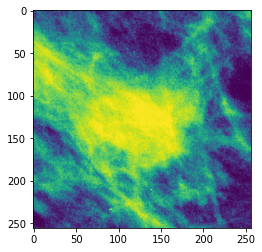

In [25]:
plt.imshow(img[0,0,:])


In [44]:
np.sum(np.array(mask == 0))

109180

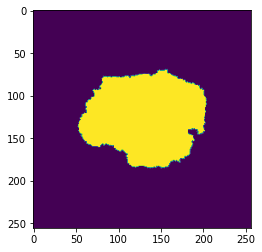

In [26]:
plt.imshow(mask[0,0,:])

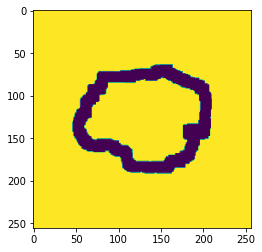

In [27]:
plt.imshow(weights[0,0,:])

## Convert image data into nnunet format 

In [8]:
os.makedirs(target_imagesTr, exist_ok=True)
os.makedirs(target_labelsTs, exist_ok=True)
os.makedirs(target_imagesTs, exist_ok=True)
os.makedirs(target_labelsTr, exist_ok=True)

In [9]:
# convert the training examples.
input_dir_tr = join(base, 'train')

training_cases = []
# with open(train_images_filename,'r') as train_file:
#     for line in train_file.readlines():
#         training_cases.append(line[2:-1])
for root, dirs, files in os.walk(input_dir_tr):
    for file in files:
        if file.endswith(".npy"):
             training_cases.append(os.path.join(root, file))


In [28]:
for t in training_cases:
    unique_name = os.path.splitext(os.path.split(t)[-1])[0]  # just the filename with the extension cropped away, so img-2.png becomes img-2 as unique_name
    input_file = t

    img = np.load(input_file)
    img = img.copy()

    img_r = cv2.resize(img[0], (640,640))
    mask = cv2.resize(img[1], (640,640))

    output_image_file = join(target_imagesTr, unique_name)  # do not specify a file ending! This will be done for you
    output_seg_file = join(target_labelsTr, unique_name)  # do not specify a file ending! This will be done for you
    # this utility will convert 2d images that can be read by skimage.io.imread to nifti. You don't need to do anything.
    # if this throws an error for your images, please take a look at the code for this function and adapt it to your needs
    train_img = convert_2d_image_to_nifti(img_r.copy(), output_image_file, is_seg=False)

    # nnU-Net expects the labels to be consecutive integers. This can be achieved with setting a transform
    train_seg = convert_2d_image_to_nifti(mask.copy(), output_seg_file, is_seg=True,
                                transform=lambda x: (x >= 1).astype(int))


In [29]:
# now do the same for the test set
input_dir_ts = join(base, 'validation')

testing_cases = []
for root, dirs, files in os.walk(input_dir_ts):
    for file in files:
        if file.endswith(".npy"):
             testing_cases.append(os.path.join(root, file))

for t in testing_cases:
    unique_name = os.path.splitext(os.path.split(t)[-1])[0]  # just the filename with the extension cropped away, so img-2.png becomes img-2 as unique_name
    input_file = t

    img = np.load(input_file)
    img = img.copy()

    img_r = cv2.resize(img[0], (640,640))
    mask = cv2.resize(img[1], (640,640))

    output_image_file = join(target_imagesTs, unique_name)  # do not specify a file ending! This will be done for you
    output_seg_file = join(target_labelsTs, unique_name)  # do not specify a file ending! This will be done for you
    # this utility will convert 2d images that can be read by skimage.io.imread to nifti. You don't need to do anything.
    # if this throws an error for your images, please just look at the code for this function and adapt it to your needs
    test_img = convert_2d_image_to_nifti(img_r.copy(), output_image_file, is_seg=False)

    # nnU-Net expects the labels to be consecutive integers. This can be achieved with setting a transform
    test_seg = convert_2d_image_to_nifti(mask.copy(), output_seg_file, is_seg=True,
                                transform=lambda x: (x >= 1).astype(int))


## Visualize conversion Results

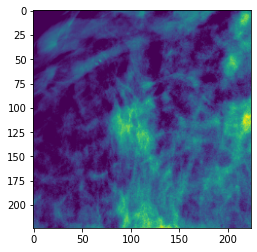

In [11]:
test_img_sitk = sitk.GetArrayFromImage(test_img)
plt.imshow(test_img_sitk[0])

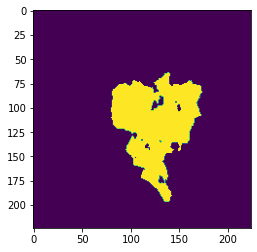

In [35]:
test_seg_sitk = sitk.GetArrayFromImage(test_seg)
plt.imshow(test_seg_sitk[0])

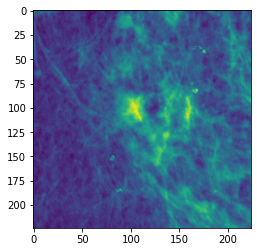

In [27]:
plt.imshow(img[0])

## Make json

In [30]:
# finally we can call the utility for generating a dataset.json
generate_dataset_json(join(target_base, 'dataset.json'), target_imagesTr, target_imagesTs, ("RGB",),
                        labels={0: 'background', 1: 'lesion'}, dataset_name=task_name, license='hands off!')


MAKE SURE TO GO INTO ~/.my-bashrc and add the below 3 lines (REPLACE THE PATHS WITH YOUR PATHS): 

export nnUNet_raw_data_base="/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base"
export nnUNet_preprocessed="/usr/xtmp/jly16/mammoproj/data/nnUNet_preprocessed"
export RESULTS_FOLDER="/usr/xtmp/jly16/mammoproj/data/nnUNet_trained_models"

In [ ]:

"""
once this is completed, you can use the dataset like any other nnU-Net dataset. Note that since this is a 2D
dataset there is no need to run preprocessing for 3D U-Nets. You should therefore run the 
`nnUNet_plan_and_preprocess` command like this:

> nnUNet_plan_and_preprocess -t 120 -pl3d None

once that is completed, you can run the trainings as follows:
> nnUNet_train 2d nnUNetTrainerV2 120 FOLD

(where fold is again 0, 1, 2, 3 and 4 - 5-fold cross validation)

there is no need to run nnUNet_find_best_configuration because there is only one model to choose from.
Note that without running nnUNet_find_best_configuration, nnU-Net will not have determined a postprocessing
for the whole cross-validation. Spoiler: it will determine not to run postprocessing anyways. If you are using
a different 2D dataset, you can make nnU-Net determine the postprocessing by using the
`nnUNet_determine_postprocessing` command
"""

## Now do the preprocessing

In [33]:
! nnUNet_plan_and_preprocess -t 504 --verify_dataset_integrity



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Verifying training set
checking case DP_AABO_1432_1
checking case DP_AABO_1435_1
checking case DP_AACA_163_1
checking case DP_AACA_167_1
checking case DP_AACA_168_1
checking case DP_AACW_1835_1
checking case DP_AACW_1837_1
checking case DP_AACW_1838_1
checking case DP_AADN_2148_1
checking case DP_AADN_2149_1
checking case DP_AADT_2227_1
checking case DP_AADU_2248_1
checking case DP_AADU_2250_1
checking case DP_AAEL_2453_1
checking case DP_AAEL_2454_1
checking case DP_AAEU_173629_1
checking case DP_AAEU_173631_1
checking case DP_AAFX_3048_1
checking case DP_AAFX_3049_1
checking case DP_AAGG_3178_1
checking case DP_AAGX_3496_1
check

## And finally run the training!

In [39]:
! sbatch train_nnunet.sh
## Fold = 0 

Submitted batch job 2859768


In [6]:
! sbatch train_nnunet.sh
# fold = 1

Submitted batch job 2765172


In [2]:
! sbatch test_nnunet.sh


Submitted batch job 2790331


## Look at test performance for CBIS-DDSM Test 

In [11]:
# these are all the files we will be dealing with
labels = sorted(glob.glob(f"{target_labelsTs}/*.nii.gz"))

pred_path = '/usr/xtmp/jly16/mammoproj/data/output/Task501_cbis-ddsm/2d'
preds = sorted(glob.glob(f"{pred_path}/*.nii.gz"))

assert np.all([os.path.basename(labels[i])==os.path.basename(preds[i]) for i in range(len(labels))]), "files don't match!"
files = [os.path.basename(labels[i]) for i in range(len(labels))]

ious = {}
for file in files: 
    label = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(target_labelsTs, file)))
    pred = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(pred_path, file)))
    ious[file] = (label&pred).sum()/(label|pred).sum()
print(f"avg iou: {np.average(list(ious.values()))}")

avg iou: 0.8151690218431723


In [12]:
df = pandas.DataFrame.from_dict(ious, orient = 'index', columns = ['iou'])
df.index.name = 'file'
df.sort_values(by = 'iou', inplace = True, ascending=False)


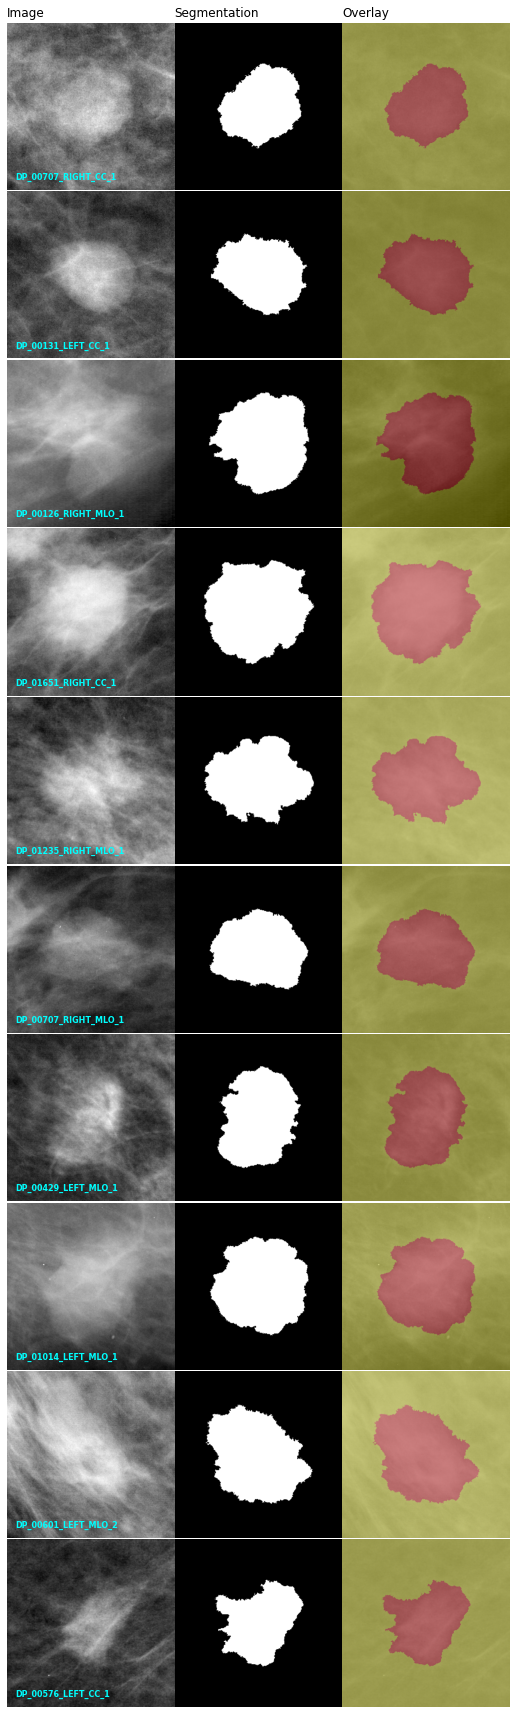

In [76]:
filepath = []
annotations = []
for i in range(10): 
    filepath.append([os.path.join(target_imagesTs, df.iloc[i].name[:-7]+ '_0000.nii.gz'), os.path.join(target_labelsTs, df.iloc[i].name)])
    annotations.append(df.iloc[i].name[:-7])
fig = display_image_annotation(filepath,annotations, niigz=True)
fig.savefig('/usr/xtmp/jly16/mammoproj/paper/figs/nnunet_base/cbis-ddsm_test/best_overlays.png')

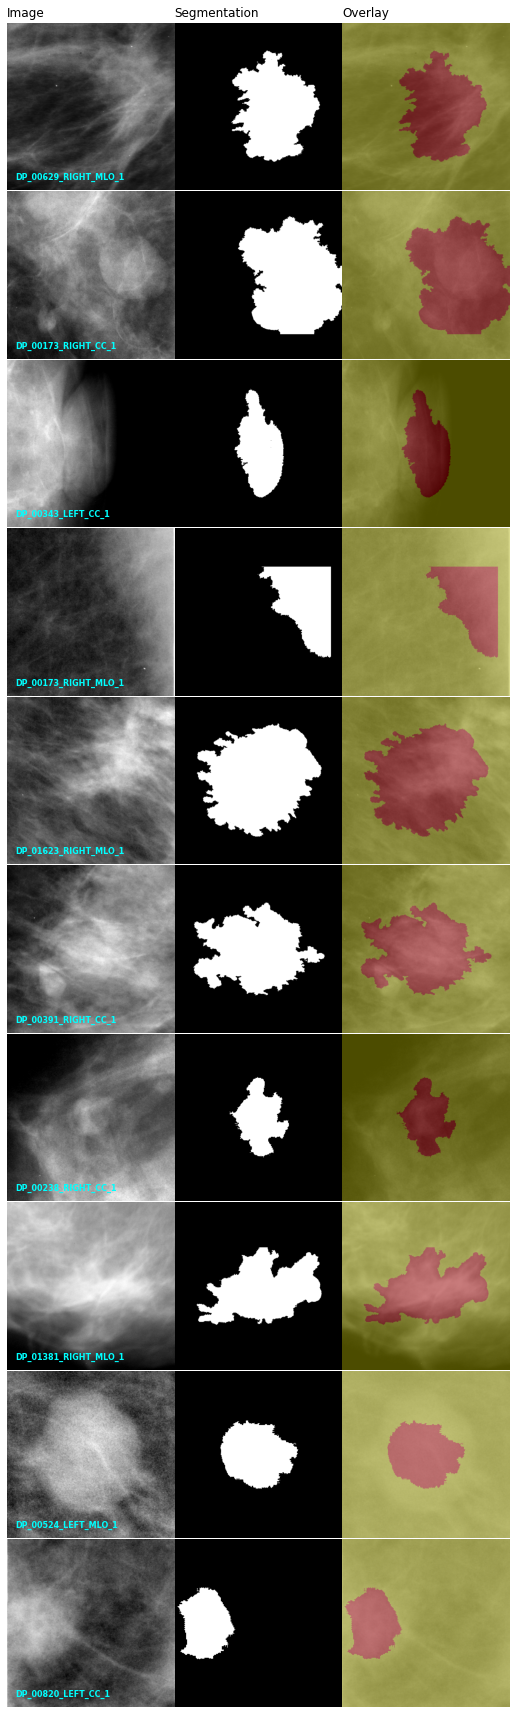

In [78]:
filepath = []
annotations = []
for i in range(10): 
    filepath.append([os.path.join(target_imagesTs, df.iloc[-(i+1)].name[:-7]+ '_0000.nii.gz'), os.path.join(target_labelsTs, df.iloc[-(i+1)].name)])
    annotations.append(df.iloc[-(i+1)].name[:-7])
fig = display_image_annotation(filepath,annotations, niigz=True)
fig.savefig('/usr/xtmp/jly16/mammoproj/paper/figs/nnunet_base/cbis-ddsm_test/worst_overlays.png')

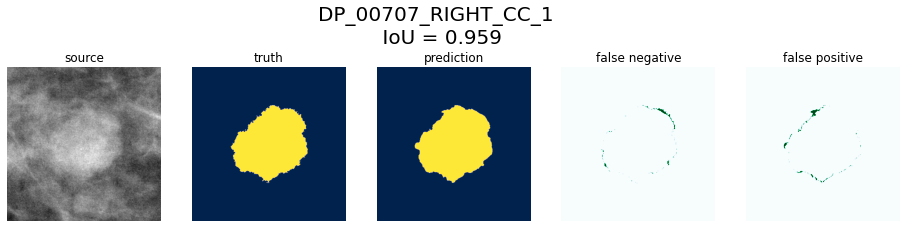

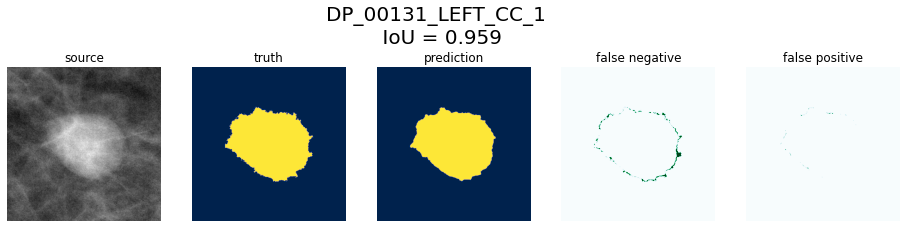

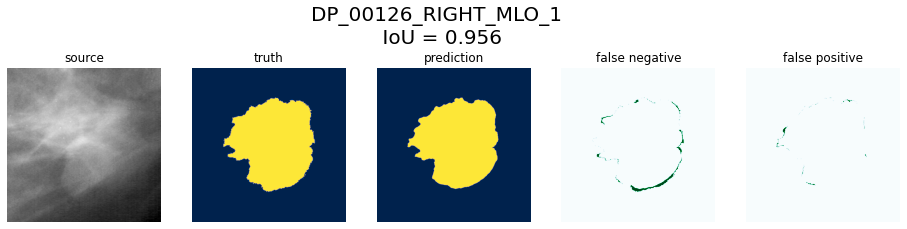

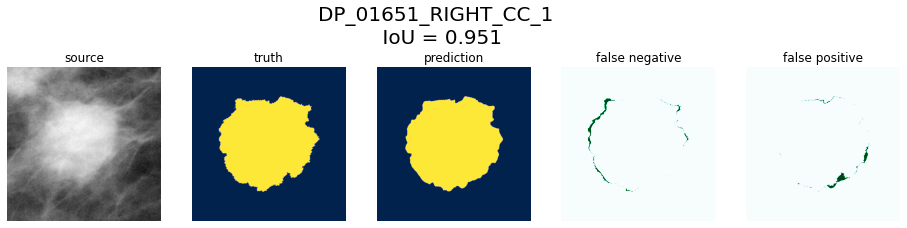

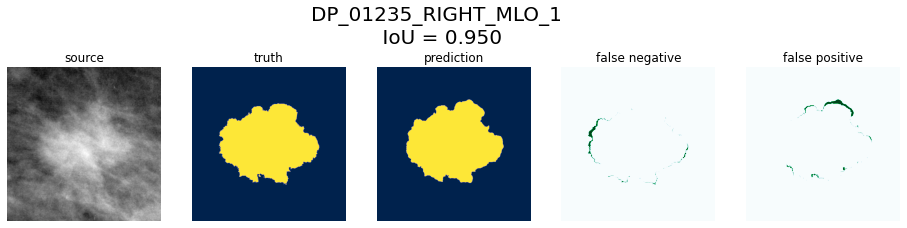

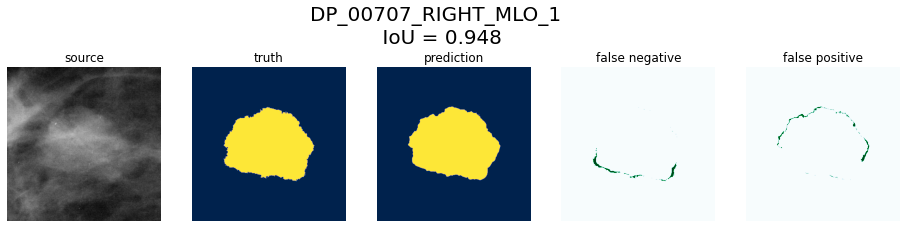

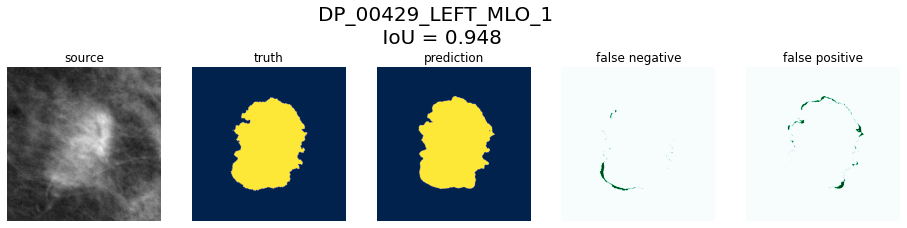

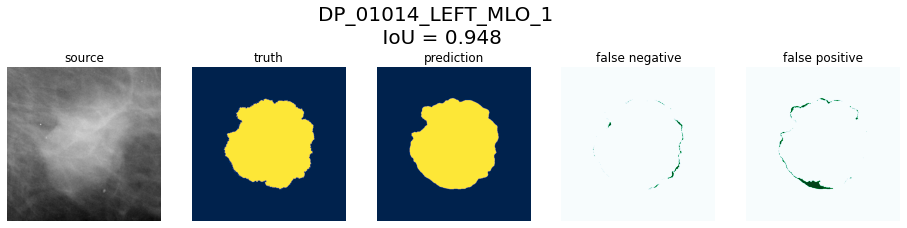

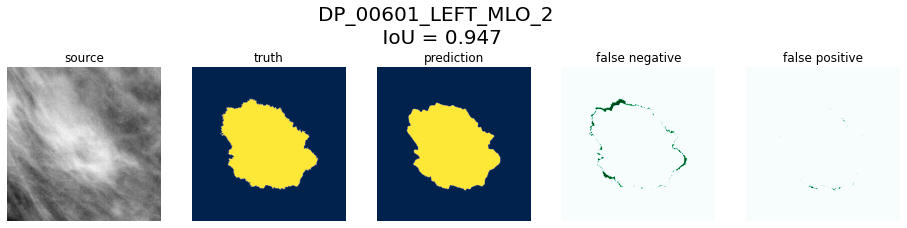

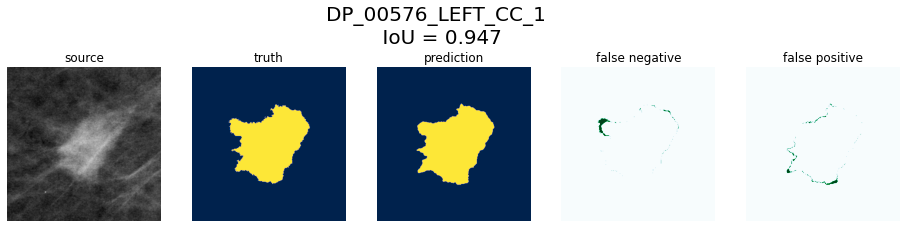

In [73]:
for i in range(10): 
    fig, ax = plt.subplots(1,5, figsize = (16,4))
    fig.suptitle(f'{df.iloc[i].name[:-7]} \n IoU = {df.iloc[i].iou :.3f}', fontsize = 20)
    img  = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(target_imagesTs, df.iloc[i].name[:-7]+ '_0000.nii.gz')))[0]
    truth = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(target_labelsTs, df.iloc[i].name)))[0]
    pred = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(pred_path, df.iloc[i].name)))[0]
    
    ax[0].set_title('source')
    ax[0].imshow(img, cmap = 'gray')
    ax[0].axis('off')

    ax[1].set_title('truth')
    ax[1].imshow(truth, cmap = 'cividis')
    ax[1].axis('off')
    
    ax[2].set_title(f'prediction')
    ax[2].imshow(pred, cmap = 'cividis')
    ax[2].axis('off')

    ax[3].set_title('false negative')
    ax[3].imshow((truth - pred )== 1, cmap = 'BuGn') 
    ax[3].axis('off')

    ax[4].set_title('false positive')
    ax[4].imshow((pred - truth )== 1, cmap = 'BuGn')
    ax[4].axis('off')

    ## TODO: Add overlay as a flag for truth and pred (use cmap = 'autumn_r') ... existing code @ remote_testing.ipyn (display_image_annotation)
    plt.show
    plt.savefig(f'../paper/figs/nnunet_base/cbis-ddsm_test/best_{i}.png')

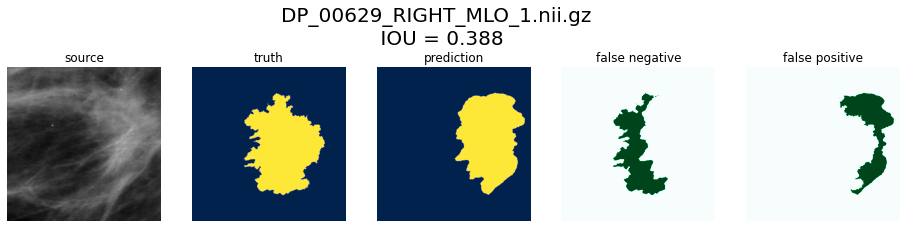

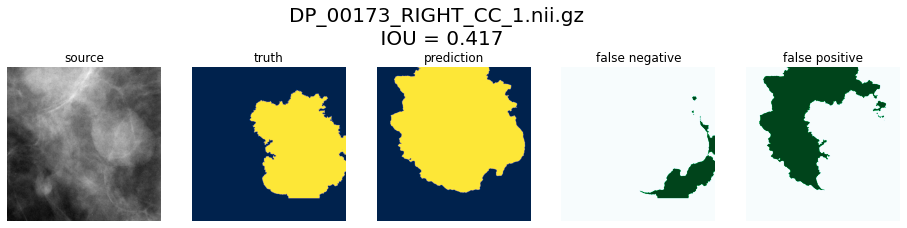

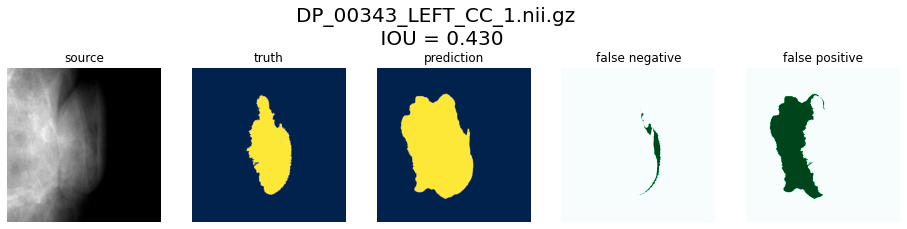

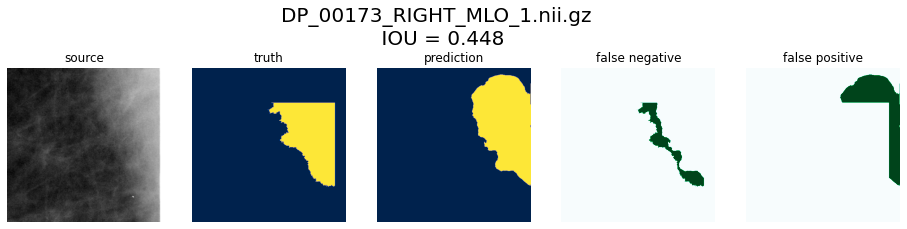

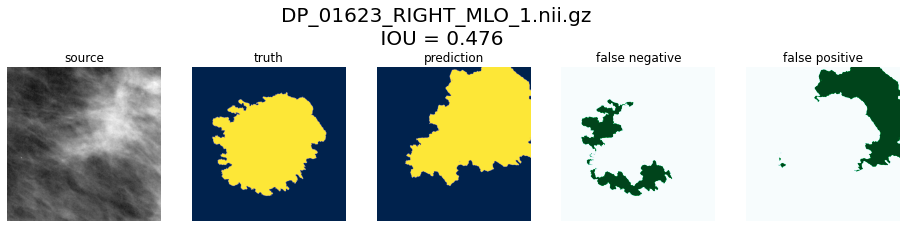

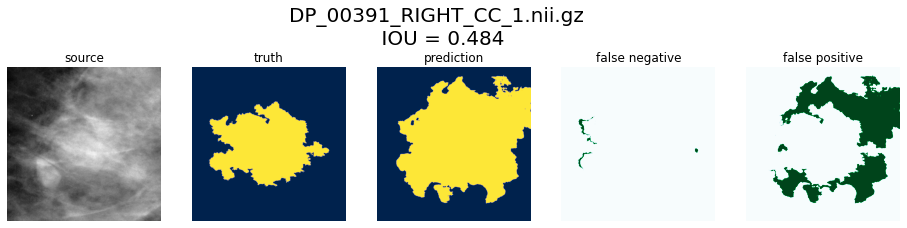

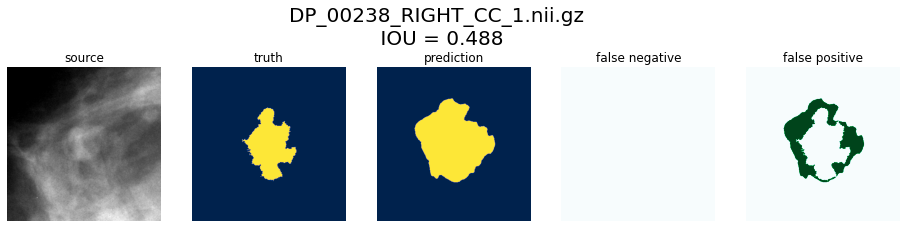

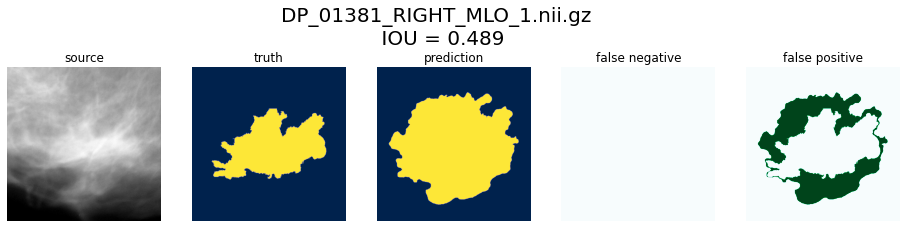

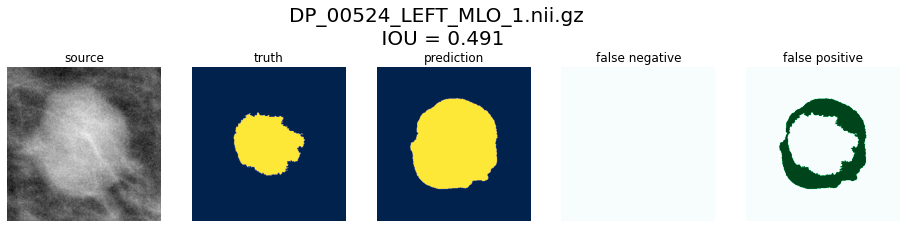

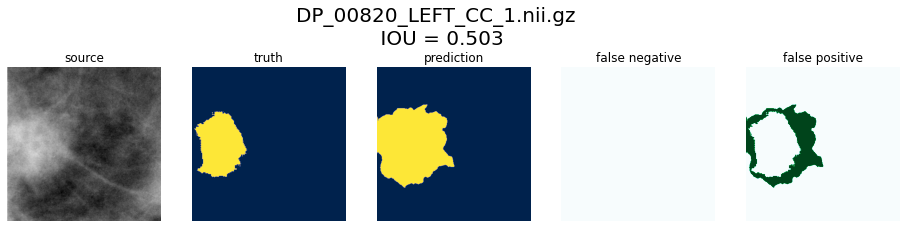

In [71]:
for i in range(10): 
    fig, ax = plt.subplots(5,5, figsize = (16,4))
    fig.suptitle(f'{df.iloc[-(i+1)].name} \n IOU = {df.iloc[-(i+1)].iou :.3f}', fontsize = 20)
    img  = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(target_imagesTs, df.iloc[-(i+1)].name[:-7]+ '_0000.nii.gz')))[0]
    truth = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(target_labelsTs, df.iloc[-(i+1)].name)))[0]
    pred = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(pred_path, df.iloc[-(i+1)].name)))[0]
    
    ax[0].set_title('source')
    ax[0].imshow(img, cmap = 'gray')
    ax[0].axis('off')

    ax[1].set_title('truth')
    ax[1].imshow(truth, cmap = 'cividis')
    ax[1].axis('off')
    
    ax[2].set_title('prediction')
    ax[2].imshow(pred, cmap = 'cividis')
    ax[2].axis('off')

    ax[3].set_title('false negative')
    ax[3].imshow((truth - pred )== 1, cmap = 'BuGn') ## TODO: LOOK FOR NEW COLOR SCHEME
    ax[3].axis('off')

    ax[4].set_title('false positive')
    ax[4].imshow((pred - truth )== 1, cmap = 'BuGn') ## LOOK FOR NEW COLOR SCHEME
    ax[4].axis('off')

    plt.show
    plt.savefig(f'../paper/figs/nnunet_base/cbis-ddsm_test/worst_{i}.png')

## Preprocess Test A vs Test B ()

In [6]:
testA = sorted(glob.glob('/usr/xtmp/vs196/mammoproj/Data/consolidated_dataset/testA/*/*[0-9].png'))
testA_seg = sorted(glob.glob('/usr/xtmp/vs196/mammoproj/Data/consolidated_dataset/testA/*/*_fa.png'))
testB = sorted(glob.glob('/usr/xtmp/vs196/mammoproj/Data/consolidated_dataset/testB/*/*[0-9].png'))
testB_seg = sorted(glob.glob('/usr/xtmp/vs196/mammoproj/Data/consolidated_dataset/testB/*/*_fa.png'))
assert np.all([os.path.basename(testA[i])==os.path.basename(testB[i]) for i in range(len(testA))]), "files don't match!"

files = [os.path.basename(testA[i]) for i in range(len(testA))]

In [9]:
target_image_dir = '/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/TestB/images'
target_label_dir = '/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/TestB/labels'

for i in range(len(testB)):

    unique_name = os.path.basename(testB[i]) # just the filename with the extension cropped away, so img-2.png becomes img-2 as unique_name

    img = plt.imread(testB[i]).copy()
    seg = plt.imread(testB_seg[i]).copy()

    output_image_file = join(target_image_dir, unique_name[:-4])  # do not specify a file ending! This will be done for you
    output_seg_file = join(target_label_dir, unique_name[:-4])  # do not specify a file ending! This will be done for you
    # this utility will convert 2d images that can be read by skimage.io.imread to nifti. You don't need to do anything.
    # if this throws an error for your images, please take a look at the code for this function and adapt it to your needs
    test_img = convert_2d_image_to_nifti(img[:,:,0].copy(), output_image_file, is_seg=False)

    # nnU-Net expects the labels to be consecutive integers. This can be achieved with setting a transform
    test_seg = convert_2d_image_to_nifti(seg[:,:,0].copy(), output_seg_file, is_seg=True,
                                transform=lambda x: (x >= 1).astype(int))


In [35]:
#    Copyright 2020 Division of Medical Image Computing, German Cancer Research Center (DKFZ), Heidelberg, Germany
#
#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at
#
#        http://www.apache.org/licenses/LICENSE-2.0
#
#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.


from typing import Tuple
import numpy as np
from batchgenerators.utilities.file_and_folder_operations import *


def get_identifiers_from_splitted_files(folder: str):
    uniques = np.unique([i[:-12] for i in subfiles(folder, suffix='.nii.gz', join=False)])
    return uniques


def generate_dataset_json(output_file: str, imagesTr_dir: str, imagesTs_dir: str, modalities: Tuple,
                          labels: dict, dataset_name: str, sort_keys=True, license: str = "hands off!", dataset_description: str = "",
                          dataset_reference="", dataset_release='0.0'):
    """
    :param output_file: This needs to be the full path to the dataset.json you intend to write, so
    output_file='DATASET_PATH/dataset.json' where the folder DATASET_PATH points to is the one with the
    imagesTr and labelsTr subfolders
    :param imagesTr_dir: path to the imagesTr folder of that dataset
    :param imagesTs_dir: path to the imagesTs folder of that dataset. Can be None
    :param modalities: tuple of strings with modality names. must be in the same order as the images (first entry
    corresponds to _0000.nii.gz, etc). Example: ('T1', 'T2', 'FLAIR').
    :param labels: dict with int->str (key->value) mapping the label IDs to label names. Note that 0 is always
    supposed to be background! Example: {0: 'background', 1: 'edema', 2: 'enhancing tumor'}
    :param dataset_name: The name of the dataset. Can be anything you want
    :param sort_keys: In order to sort or not, the keys in dataset.json
    :param license:
    :param dataset_description:
    :param dataset_reference: website of the dataset, if available
    :param dataset_release:
    :return:
    """
    train_identifiers = get_identifiers_from_splitted_files(imagesTr_dir)

    if imagesTs_dir is not None:
        test_identifiers = get_identifiers_from_splitted_files(imagesTs_dir)
    else:
        test_identifiers = []

    json_dict = {}
    json_dict['name'] = dataset_name
    json_dict['description'] = dataset_description
    json_dict['tensorImageSize'] = "4D"
    json_dict['reference'] = dataset_reference
    json_dict['licence'] = license
    json_dict['release'] = dataset_release
    json_dict['modality'] = {str(i): modalities[i] for i in range(len(modalities))}
    json_dict['labels'] = {str(i): labels[i] for i in labels.keys()}

    json_dict['numTraining'] = len(train_identifiers)
    json_dict['numTest'] = len(test_identifiers)
    json_dict['training'] = [
        {'image': "./images/%s.nii.gz" % i, "label": "./labels/%s.nii.gz" % i} for i
        in
        train_identifiers]
    json_dict['test'] = ["./images/%s.nii.gz" % i for i in test_identifiers]

    if not output_file.endswith("dataset.json"):
        print("WARNING: output file name is not dataset.json! This may be intentional or not. You decide. "
              "Proceeding anyways...")
    save_json(json_dict, os.path.join(output_file), sort_keys=sort_keys)

In [37]:
# finally we can call the utility for generating a dataset.json
target_image_dir = '/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/TestA/images'
target_label_dir = '/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/TestA/labels'

generate_dataset_json(join('/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/TestA/', 'dataset.json'), target_image_dir, None, ('RGB',),
                        labels={0: 'background', 1: 'lesion'}, dataset_name=task_name, license='hands off!')


In [4]:
! sbatch test_nnunet.sh

Submitted batch job 2802657


## Test results for Test A vs Test B

In [5]:
# these are all the files we will be dealing with
target_image_dir = '/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/TestB/images'
target_labels_dirA = '/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/TestA/labels'
target_labels_dirB = '/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/TestB/labels'

labelsA = sorted(glob.glob(os.path.join(target_labels_dirA,"*.nii.gz")))
labelsB = sorted(glob.glob(os.path.join(target_labels_dirA,"*.nii.gz")))

pred_path = '/usr/xtmp/jly16/mammoproj/data/output/Test/2d/'
preds = sorted(glob.glob(os.path.join(pred_path,"*.nii.gz")))
assert np.all([os.path.basename(labelsA[i])==os.path.basename(labelsB[i]) for i in range(len(labelsA))]), "files don't match!"
assert np.all([os.path.basename(labelsA[i])==os.path.basename(preds[i]) for i in range(len(labelsA))]), "files don't match!"

files = [os.path.basename(labelsA[i]) for i in range(len(labelsA))]

ious = {}
for file in files: 
    labelA = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(target_labels_dirA, file))) * -1 + 1
    labelB = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(target_labels_dirB, file))) * -1 + 1
    pred = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(pred_path, file)))
    ious[file] = ((labelA&labelB).sum()/(labelA|labelB).sum(), 
                  (labelA&pred).sum()/(labelA|pred).sum(), 
                  (labelB&pred).sum()/(labelB|pred).sum())

# print(f"avg iou: {np.average(list(ious.values()))}")

In [23]:
df = pandas.DataFrame.from_dict(ious, orient = 'index', columns = ['A vs B', 'A vs Pred', 'B vs Pred'])
df['Max Pred'] = df[['A vs Pred','B vs Pred']].max(axis=1)
df['Avg Pred'] = (df['A vs Pred'] + df['B vs Pred'] ) * 0.5
df['Min Diff'] = df['A vs B'] - df['Max Pred']
df.index.name = 'file'
df.sort_values(by = 'Min Diff', inplace = True, ascending=True)

In [50]:
df.mean(), df.std()

(A vs B       0.732840
 A vs Pred    0.574414
 B vs Pred    0.549356
 Max Pred     0.610629
 Avg Pred     0.561885
 Min Diff     0.240515
 dtype: float64,
 A vs B       0.230338
 A vs Pred    0.225156
 B vs Pred    0.250334
 Max Pred     0.220657
 Avg Pred     0.223531
 Min Diff     0.199916
 dtype: float64)

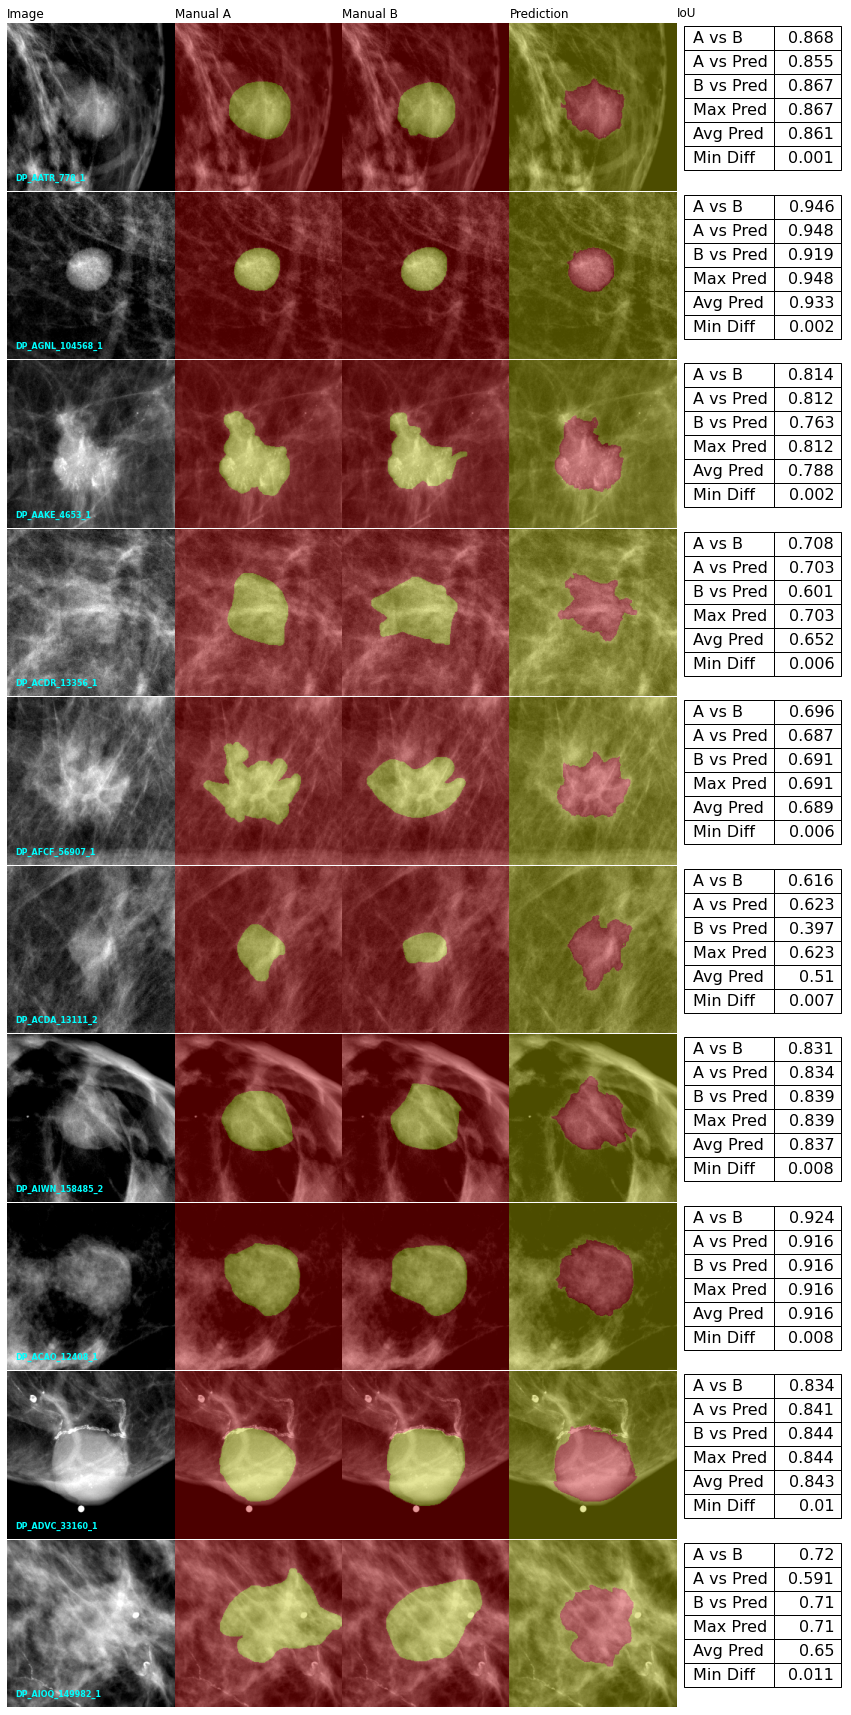

In [25]:
filepath = []
annotations = []
table_data = []
table_row_labels = df.columns

for i in range(10): 
    filepath.append([os.path.join(target_image_dir, df.iloc[i].name[:-7]+ '_0000.nii.gz'),
                     os.path.join(target_labels_dirA, df.iloc[i].name),
                     os.path.join(target_labels_dirB, df.iloc[i].name),
                     os.path.join(pred_path, df.iloc[i].name)
    ])
    annotations.append(df.iloc[i].name[:-7])
    table_data.append(df.round(3).iloc[i:i+1].values.T)

fig = display_image_annotation_AB(filepath, annotations, table_data, table_row_labels, overlay = True)
fig.savefig('/usr/xtmp/jly16/mammoproj/paper/figs/nnunet_base/testAvsB/test_best_overlays.png', bbox_inches = 'tight')

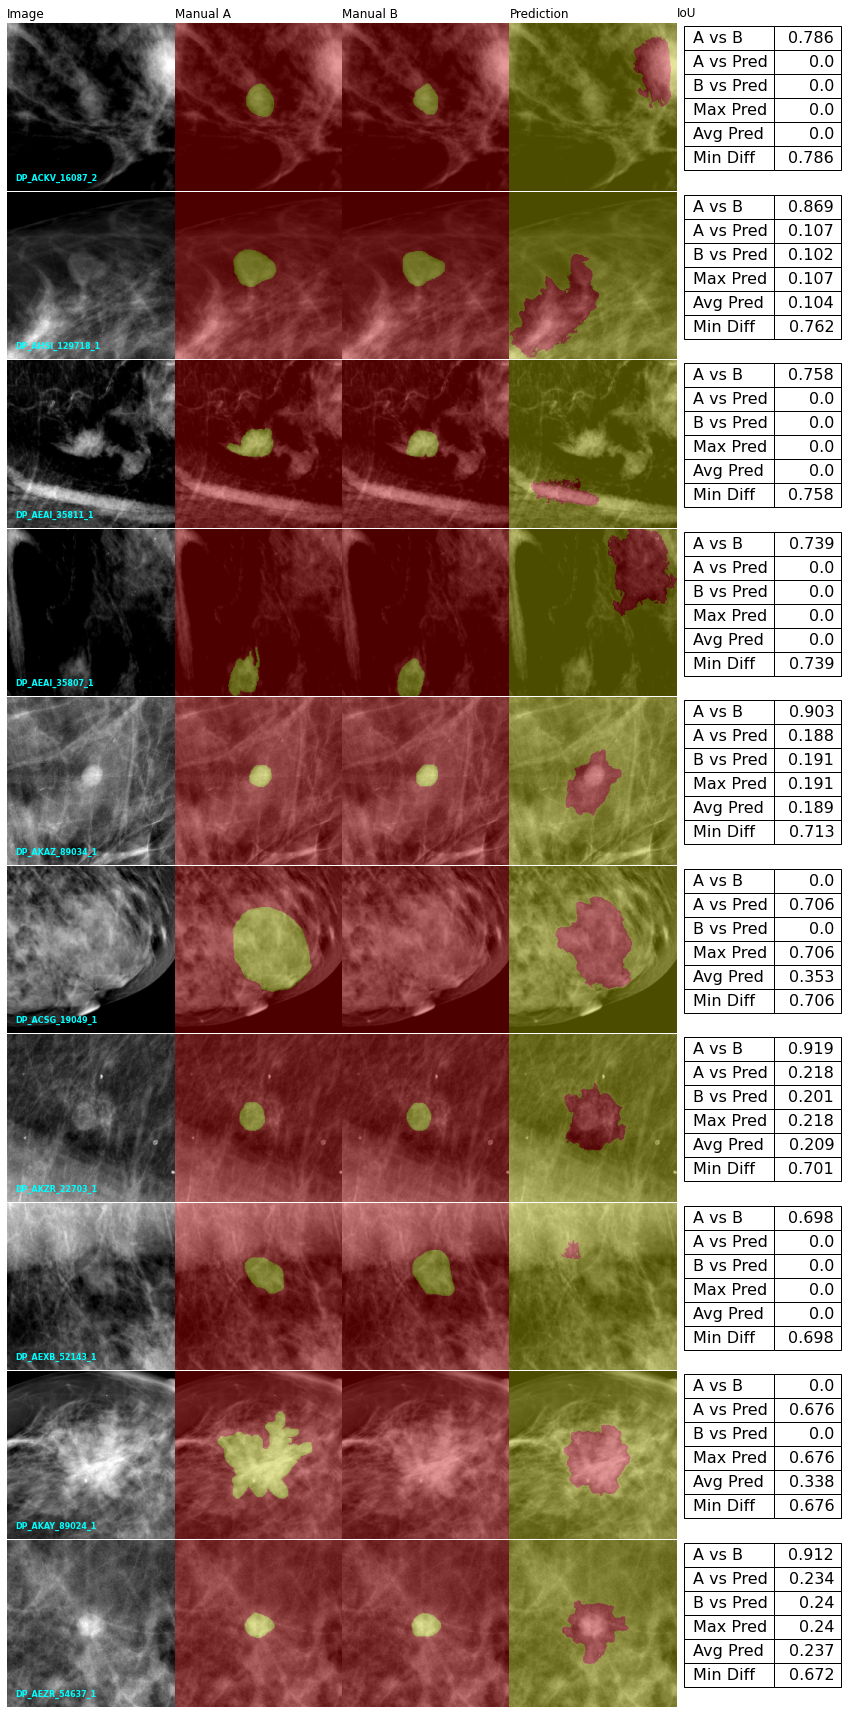

In [48]:
filepath = []
annotations = []
table_data = []
table_row_labels = df.columns

for i in range(10): 
    filepath.append([os.path.join(target_image_dir, df.iloc[-(i+1)].name[:-7]+ '_0000.nii.gz'),
                     os.path.join(target_labels_dirA, df.iloc[-(i+1)].name),
                     os.path.join(target_labels_dirB, df.iloc[-(i+1)].name),
                     os.path.join(pred_path, df.iloc[-(i+1)].name)
    ])
    annotations.append(df.iloc[-(i+1)].name[:-7])
    table_data.append(pandas.DataFrame(df.round(3).iloc[-(i+1)]).values)

fig = display_image_annotation_AB(filepath, annotations, table_data, table_row_labels, overlay = True)
fig.savefig('/usr/xtmp/jly16/mammoproj/paper/figs/nnunet_base/testAvsB/test_worst_overlays.png', bbox_inches = 'tight')

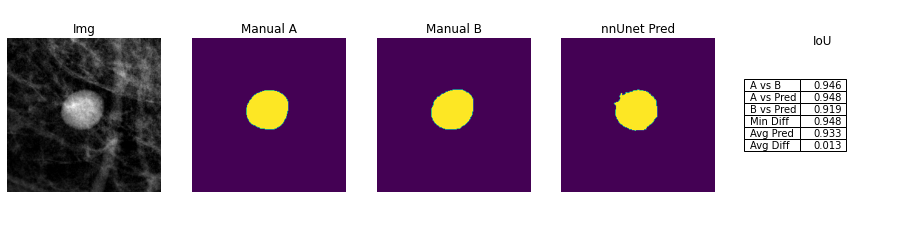

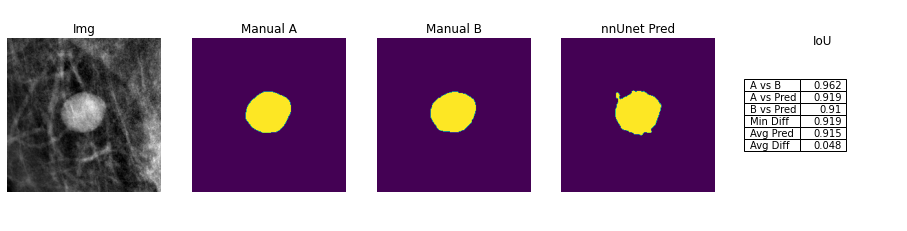

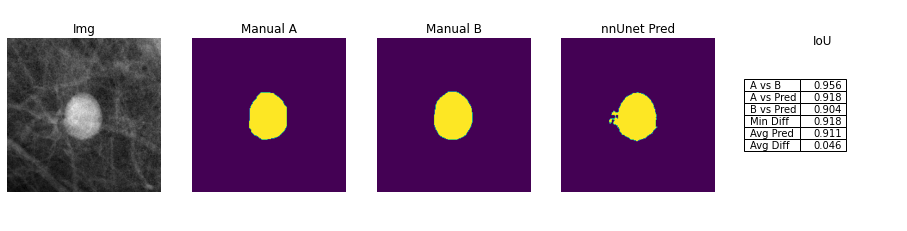

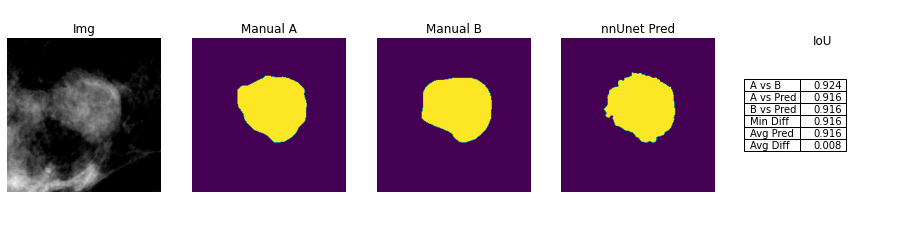

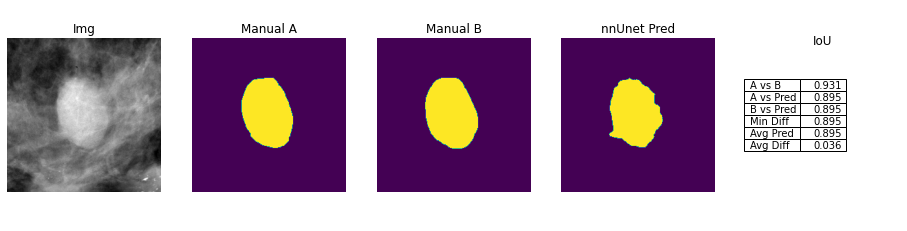

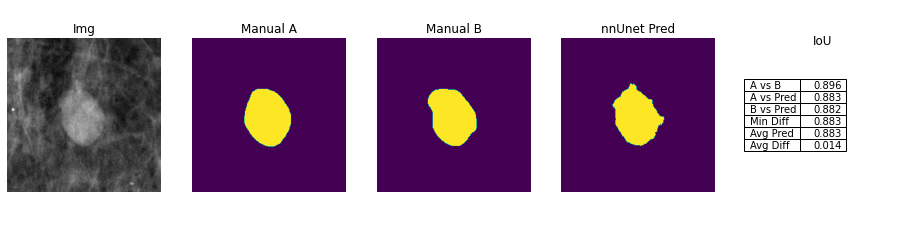

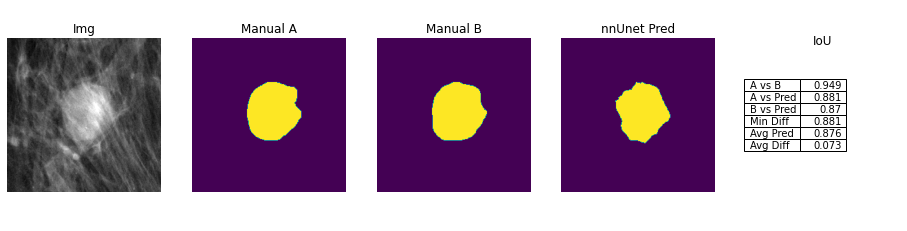

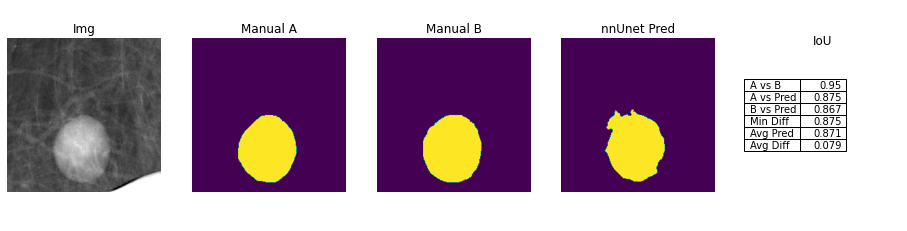

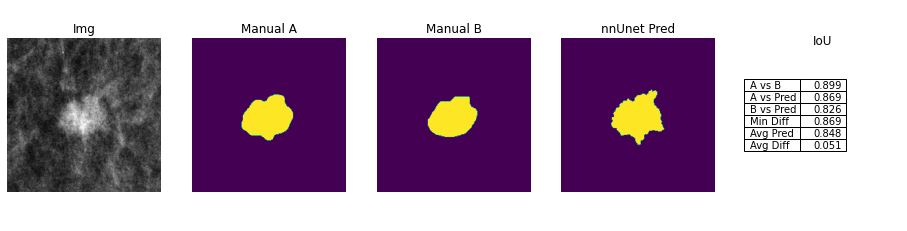

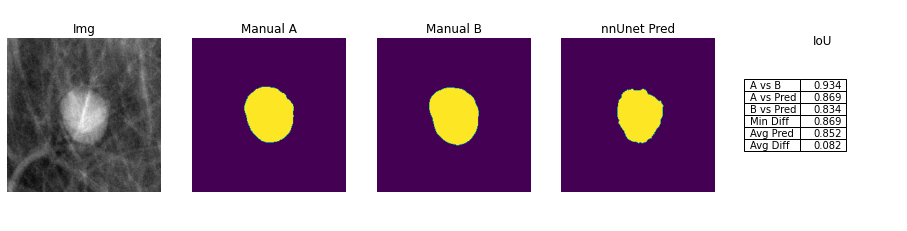

In [ ]:
fig, ax = plt.subplots(1,5, figsize = (16,4))
fig.suptitle(f'{df.iloc[-(i+1)].name} \n IOU = {df.iloc[-(i+1)].iou :.3f}', fontsize = 20)
ax[0].set_title("Image", fontdict=None, loc='left', color = "k")
            
for i in range(10): 
    img  = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(target_image_dir, df.iloc[i].name[:-7]+ '_0000.nii.gz')))[0]
    truthA = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(target_labels_dirA, df.iloc[i].name)))[0] * -1 + 1
    truthB = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(target_labels_dirB, df.iloc[i].name)))[0] * -1 + 1
    pred = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(pred_path, df.iloc[i].name)))[0]
    
    ax[0].set_title('Img')
    ax[0].imshow(img, cmap = 'gray')    
    ax[0].axis('off')

    ax[1].set_title('Manual A')
    ax[1].imshow(truthA, cmap = 'cividis')    
    ax[1].axis('off')
    
    ax[2].set_title('Manual B')
    ax[2].imshow(truthB, cmap = 'cividis')    
    ax[2].axis('off')

    ax[3].set_title('nnUnet Pred')
    ax[3].imshow(pred, cmap = 'cividis')
    ax[3].axis('off')

    ax[4].set_title('IoU', y = .8)
    ax[4].table(cellText=df.round(3).iloc[i:i+1].values.T, rowLabels=df.columns, loc = 'center', colWidths = [.3,.4])    
    ax[4].axis('off')

    plt.show

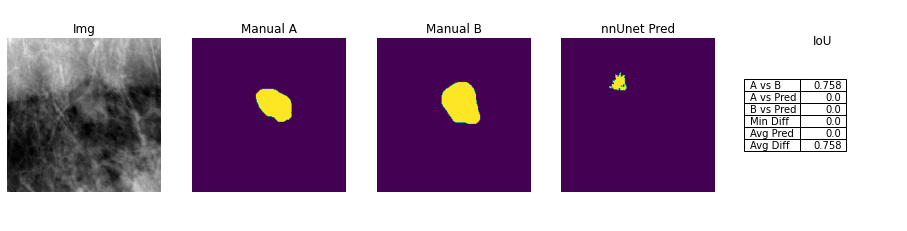

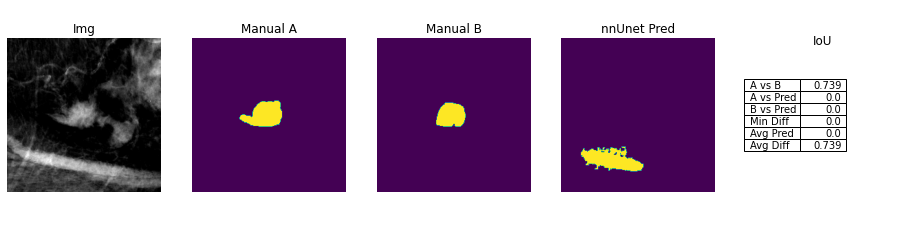

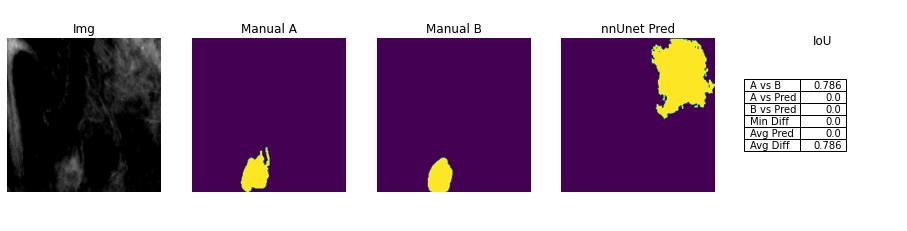

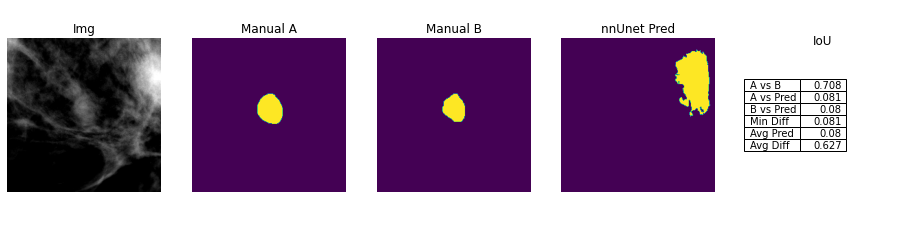

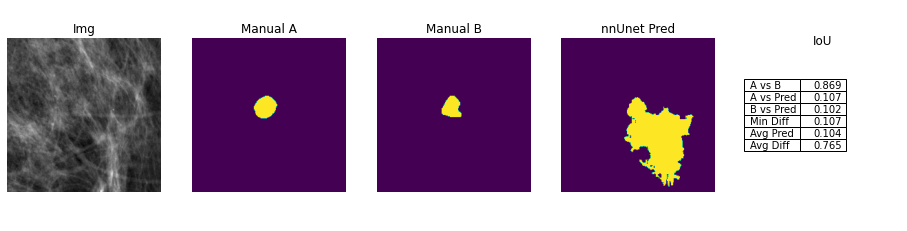

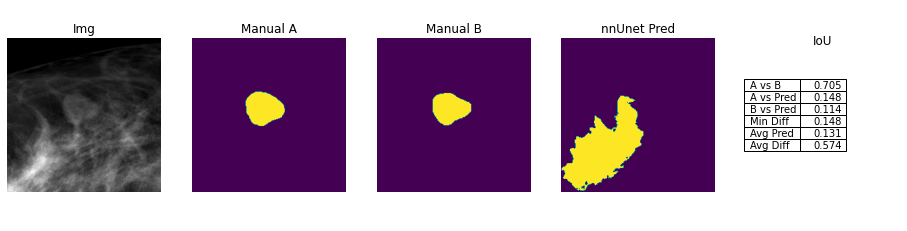

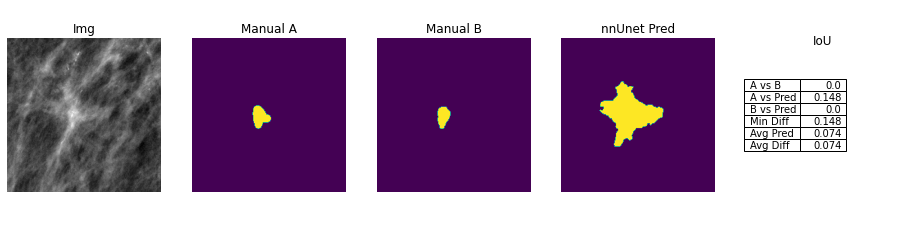

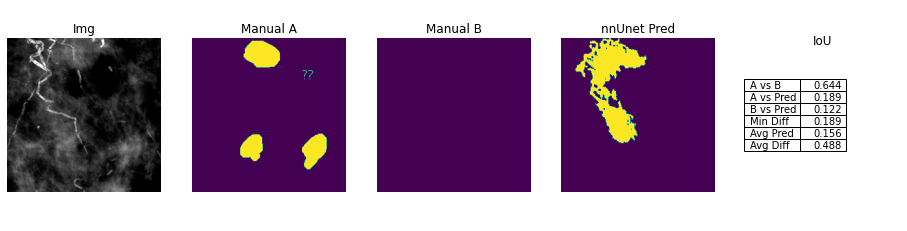

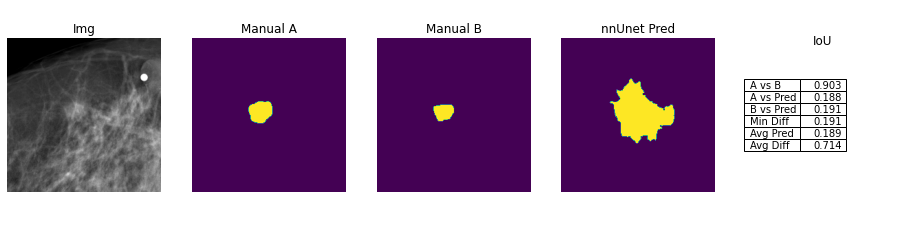

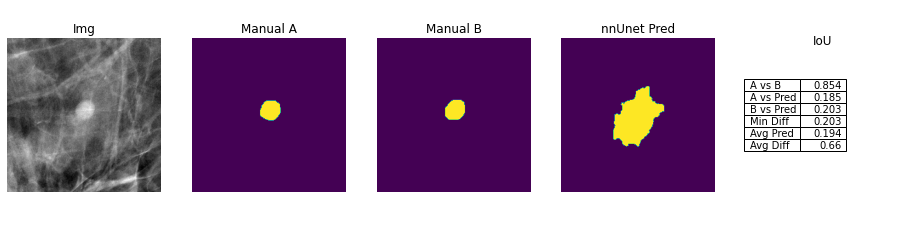

In [ ]:
for i in range(10): 
    fig, ax = plt.subplots(1,5, figsize = (16,4))
    # fig.suptitle(f'{df.iloc[i].name}, iou = {df.iloc[i].iou}')
    img  = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(target_image_dir, df.iloc[-(i+1)].name[:-7]+ '_0000.nii.gz')))[0]
    truthA = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(target_labels_dirA, df.iloc[-(i+1)].name)))[0] * -1 + 1
    truthB = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(target_labels_dirB, df.iloc[-(i+1)].name)))[0] * -1 + 1
    pred = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(pred_path, df.iloc[-(i+1)].name)))[0]
    
    ax[0].set_title('Img')
    ax[0].imshow(img, cmap = 'gray')    
    ax[0].axis('off')

    ax[1].set_title('Manual A')
    ax[1].imshow(truthA)    
    ax[1].axis('off')
    
    ax[2].set_title('Manual B')
    ax[2].imshow(truthB)    
    ax[2].axis('off')

    ax[3].set_title('nnUnet Pred')
    ax[3].imshow(pred)
    ax[3].axis('off')

    ax[4].set_title('IoU', y = .8)
    ax[4].table(cellText=df.round(3).iloc[-(i+1)-1:-(i+1)].values.T, rowLabels=df.columns, loc = 'center', colWidths = [.3,.4])    
    ax[4].axis('off')

    ## TODO: Add overlay as a flag for truth and pred (use cmap = 'autumn_r') ... existing code @ remote_testing.ipyn (display_image_annotation)
    ## TODO: remove axes, remove file extension, truncate iou

    plt.show

## Scratch Below

In [ ]:
img = np.load(
    '/usr/xtmp/mammo/image_datasets/cbis_ddsm/splitby_shape_hasFA/Train/OVAL/DP_00797_LEFT_MLO_1.npy')

In [ ]:
plt.imshow(img[1])

In [ ]:
nnUNet_raw_data = '/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/'

# now start the conversion to nnU-Net:
task_name = 'Task501_cbis-ddsm'
target_base = join(nnUNet_raw_data, task_name)
target_imagesTr = join(target_base, "imagesTr")
target_imagesTs = join(target_base, "imagesTs")
target_labelsTs = join(target_base, "labelsTs")
target_labelsTr = join(target_base, "labelsTr")

pkl = "/home/fabian/PhD/results/nnUNetV2/nnUNetV2_3D_fullres/Task004_Hippocampus/fold0/model_best.model.pkl"
checkpoint = pkl[:-4]
train = False
trainer = restore_model(pkl, checkpoint, train)


## Preprocess Duke Train

In [6]:
duke_train = sorted(glob.glob('/usr/xtmp/vs196/mammoproj/Data/total_image_dataset/train/*/*[0-9].npy'))